In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import prometheus_client
import prometheus_api_client as prom_api
import requests
import datetime
from prometheus_client.parser import text_string_to_metric_families

class PrometheusConnectWrapper:
    def __init__(self, prometheus_url: str):
        self.prom = prom_api.PrometheusConnect(url = prometheus_url, disable_ssl=True)

    def perform_query(self, query: str):
        return self.prom.custom_query(query=query)

    def fetch_metric_range_data(self, metric_name: str, start_time: float, end_time: float, label_config: dict) -> list:
        return self.prom.get_metric_range_data(metric_name=metric_name,
                                              start_time=start_time,
                                              end_time=end_time,
                                              label_config=label_config)
    def fetch_query_range(self, query: str, start_time: float, end_time: float):
        return self.prom.custom_query_range(query=query, start_time=start_time, end_time=end_time, step=1)

In [56]:
PROMETHEUS_URL = "http://localhost:9090/"
METRIC = "rest_client_requests_total"
START_TIME = datetime.datetime.now() - datetime.timedelta(minutes=30)
END_TIME = datetime.datetime.now()
LABEL_CONFIG = {"code": "200", "host": "kind-control-plane:6443","instance": "kind-control-plane","job":"kubernetes-nodes","method":"PUT"}
LABEL_CONFIG_STR = '{code="200",host="kind-control-plane:6443",instance="kind-control-plane",job="kubernetes-nodes",method="PUT"}'
QUERY = "rate(rest_client_requests_total" + LABEL_CONFIG_STR + "[1m])"

data_collector = PrometheusConnectWrapper(PROMETHEUS_URL)
print(data_collector.perform_query(QUERY))

# metric_range = data_collector.fetch_metric_range_data(metric_name=METRIC,
#                                      start_time=START_TIME,
#                                      end_time=END_TIME,
#                                      label_config=LABEL_CONFIG)

metric_range = data_collector.fetch_query_range(query=QUERY,
                                     start_time=START_TIME,
                                     end_time=END_TIME)

[{'metric': {'code': '200', 'host': 'kind-control-plane:6443', 'instance': 'kind-control-plane', 'job': 'kubernetes-nodes', 'method': 'PUT'}, 'value': [1615313495.316, '0.08888888888888888']}]


In [58]:
metric = metric_range[0]
# metric_name = metric["metric"]["__name__"]

metric_timestamps = [datetime.datetime.utcfromtimestamp(t) for t, _ in metric["values"]]
metric_values = [v for _, v in metric["values"]]

In [61]:
metric_df = pd.DataFrame(metric_values, columns=[QUERY], index=metric_timestamps)

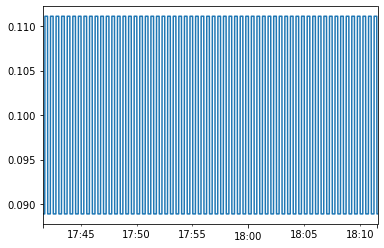

In [62]:
metric_df=metric_df.astype(float)
metric_df[QUERY].plot()
plt.show()